In [3]:
import LoadBatches
from VGGModelUnet import VGGUnet
from VGGModelUnet import set_keras_backend
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import backend as K
from keras_radam import RAdam
import numpy as np
import tensorflow as tf
import os
import cv2
import glob
from matplotlib import pyplot as plt
import seaborn as sns

plt.style.use('seaborn-ticks')
sns.set_style('ticks')
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

%matplotlib inline
#import theano.tensor as T

/Applications/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [21]:
test_images_path = "./data/test/"
test_segs_path = "./data/testmask/"
test_pred_path = "./data/testpredictions/"
# test_pred_path = "./testpredictionsaug/"
test_batch_size = 1

train_images_path = "./data/train/"
train_segs_path = "./data/trainmask/"
train_batch_size = 6
n_classes = 2  #7
#n_classes = 4

#input_height = 360
#input_width = 480
input_height = 224
input_width = 224
save_weights_path = "./weights/"
epochs = 10 #600
load_weights = ""
load_weights = "weights/VGGUnet.weights.best.original.hdf5"
checkpoint_filepath = "weights/VGGUnet.weights.best.original.hdf5"

val_images_path = "./data/val/"
val_segs_path = "./data/valmask/"
val_batch_size = 6

In [2]:
def dice_coef(y_true, y_pred):
    smooth = 1e-8
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection) / (
            K.sum(K.square(y_true_f), -1) + K.sum(K.square(y_pred_f), -1) + smooth)

    #return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def dice_coef_multilabel(y_true, y_pred):
    dice = [0, 0, 0, 0]
    for index in range(n_classes):
        dice -= dice_coef(y_true[:, :, :, index], y_pred[:, :, :, index])
    return dice


# Ref: salehi17, "Twersky loss function for image segmentation using 3D FCDN"
# -> the score is computed for each class separately and then summed
# alpha=beta=0.5 : dice coefficient
# alpha=beta=1   : tanimoto coefficient (also known as jaccard)
# alpha+beta=1   : produces set of F*-scores
# implemented by E. Moebel, 06/04/18
def tversky_loss(y_true, y_pred):
    alpha = 0.5
    beta  = 0.5
    
    ones = K.ones(K.shape(y_true))
    p0 = y_pred      # proba that voxels are class i
    p1 = ones-y_pred # proba that voxels are not class i
    g0 = y_true
    g1 = ones-y_true
    
    num = K.sum(p0*g0, (0,1,2))
    den = num + alpha*K.sum(p0*g1,(0,1,2)) + beta*K.sum(p1*g0,(0,1,2))
    
    T = K.sum(num/den) # when summing over classes, T has dynamic range [0 Ncl]
    
    Ncl = K.cast(K.shape(y_true)[-1], 'float32')
    return Ncl-T



gamma = 2.0
alpha = 0.25

def focal_loss(y_true, y_pred):
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
    cross_entropy = -y_true * K.log(y_pred)
    weight = alpha * y_true * K.pow((1 - y_pred), gamma)
    loss = weight * cross_entropy
    loss = K.sum(loss, axis=1)
    return loss

def categorical_focal_loss(y_true, y_pred):

    focal = [0, 0, 0, 0]
    for index in range(n_classes):
        focal -= (focal_loss(y_true[:, :, :, index], y_pred[:, :, :, index]))

    return focal

In [4]:
def get_model_memory_usage(batch_size, model):
    import numpy as np
    from keras import backend as K

    shapes_mem_count = 0
    for l in model.layers:
        single_layer_mem = 1
        for s in l.output_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in set(model.trainable_weights)])
    non_trainable_count = np.sum([K.count_params(p) for p in set(model.non_trainable_weights)])

    number_size = 4.0
    if K.floatx() == 'float16':
         number_size = 2.0
    if K.floatx() == 'float64':
         number_size = 8.0

    total_memory = number_size*(batch_size*shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3)
    return gbytes

In [5]:
def show_original(img):
    img = np.rollaxis(img, 0, 3)
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img.astype(np.int32)
    plt.imshow(img)

In [6]:
def test(m, output_width, output_height, output_path):
    K.set_learning_phase(0)    

    m.compile(RAdam(learning_rate=1e-4),
              loss=dice_loss, 
              metrics=[dice_coef])

    images = glob.glob(test_images_path + "*.jpg") + glob.glob(test_images_path + "*.png") + glob.glob(test_images_path + "*.jpeg")
    images.sort()
    segmentations = glob.glob(output_path + "*.jpg") + glob.glob(output_path + "*.png") + glob.glob(output_path + "*.jpeg")
    segmentations.sort()

    for i in range(len(images)):
        im_path=images[i]
        seg_path=segmentations[i]
        data=LoadBatches.getImageArr(im_path, input_width, input_height)
        data=np.expand_dims(data, axis=0) 
        predictions=m.predict(data)
        seg = predictions[0]
        #seg=np.reshape(seg,(output_width, output_height, n_classes))
        threshold=0.5
        img=np.zeros((output_width, output_height, 3),int)
        if (n_classes==2):
            #img[:,:,0]=(seg[:,:,1] >= threshold).astype(int)*255
            #Bladder
            img[:,:,0]=(seg[:,:,1] >= threshold).astype(int)*255
            img[:,:,1]=(seg[:,:,1] >= threshold).astype(int)*255
            img[:,:,2]=(seg[:,:,1] >= threshold).astype(int)*255
        elif (n_classes==4):
            #img[:,:,0]=seg[:,:,1]*255
            #img[:,:,1]=seg[:,:,2]*255
            #img[:,:,2]=seg[:,:,3]*255
            img[:,:,0]=(seg[:,:,1] >= threshold).astype(int)*255
            img[:,:,1]=(seg[:,:,2] >= threshold).astype(int)*255
            img[:,:,2]=(seg[:,:,3] >= threshold).astype(int)*255
        else:
            for c in range(n_classes):
                img[:,:,0]=(seg[:,:,c] >= threshold).astype(int)*c
                img[:,:,1]=(seg[:,:,c] >= threshold).astype(int)*c
                img[:,:,2]=(seg[:,:,c] >= threshold).astype(int)*c
            

        filename = seg_path  
        cv2.imwrite(filename, img) 

    K.clear_session()

In [7]:
def train(m, output_width, output_height):
    #m.compile(RAdam(lr=1e-3),
    #          loss=dice_coef_multilabel, 
    #          metrics=[tversky_loss, dice_coef, dice_coef_multilabel, focal_loss, categorical_focal_loss])
    m.compile(RAdam(learning_rate=1e-4),
              loss=dice_loss, 
              metrics=[tversky_loss, dice_coef, dice_coef_multilabel, focal_loss])

#     train_gen = LoadBatches.imageSegmentationGenerator(train_images_path, train_segs_path, 
#                                                        train_batch_size, n_classes,
#                                                        input_height, input_width, 
#                                                        output_height, output_width)
    train_gen = LoadBatches.augmentedDataGenerator(train_images_path, train_segs_path, 
                                                   train_batch_size, n_classes,
                                                   input_height, input_width, 
                                                   output_height, output_width)

    val_gen = LoadBatches.imageSegmentationGenerator(val_images_path, val_segs_path, 
                                                     val_batch_size, n_classes, 
                                                     input_height, input_width, 
                                                     output_height, output_width)

    print()

    model_checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True)

    model_tensorboard = TensorBoard(log_dir='./Tensorboard/logs', histogram_freq=0, batch_size=train_batch_size, 
                                        write_graph=True, write_grads=False, write_images=False, 
                                        embeddings_freq=0, embeddings_layer_names=None, 
                                        embeddings_metadata=None, embeddings_data=None, 
                                        update_freq='batch')

    gbytes = get_model_memory_usage(train_batch_size,m)
    print('Total estimated memory GBtytes: %f' % gbytes)

    m.fit_generator(train_gen, steps_per_epoch=int(78 / train_batch_size), 
                    validation_data=val_gen, 
                    callbacks=[model_checkpoint,model_tensorboard],
                    validation_steps=int(20 / val_batch_size), 
                    epochs=epochs)
    m.save_weights(save_weights_path + "finalweights.hdf5")
    m.save(save_weights_path + ".model.finalweights.hdf5")

In [22]:
# if __name__ == '__main__':
#     os.environ["CUDA_VISIBLE_DEVICES"] = "1"

set_keras_backend("tensorflow")
m, output_width, output_height = VGGUnet(n_classes)

# m.compile(loss=dice_coef_multilabel,
#           optimizer='adadelta',
#           metrics=['accuracy'])

# m.compile(loss='categorical_crossentropy',
#           optimizer='adadelta',
#           metrics=['accuracy'])

if len(load_weights) > 0:
    m.load_weights(load_weights)

print("Model output shape", m.output_shape)

# print(m.summary(line_length=150))

# train(m, output_width, output_height)
# test(m, output_width, output_height, test_pred_path)

Model output shape (None, 224, 224, 2)


(25, 3, 224, 224) (25, 224, 224, 2) (3, 224, 224)


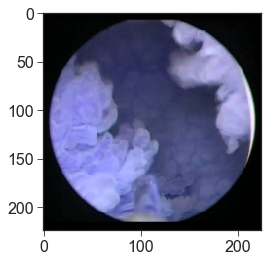

In [23]:
from keras import metrics
K.set_learning_phase(0)    

m.compile(RAdam(learning_rate=1e-4),
          loss=dice_loss, 
          metrics=[dice_coef,'acc'])

X_test, y_test = LoadBatches.imageSegmentationArray(test_images_path, test_segs_path, 
                                                    test_batch_size, n_classes,
                                                    input_height, input_width, 
                                                    output_height, output_width)

print(X_test.shape, y_test.shape, X_test[0].shape)
show_original(X_test[2].copy())

** Evaluate the model on the test set **

In [10]:
print(m.evaluate(x=X_test, y=y_test, batch_size=test_batch_size))
m.metrics_names

W0119 16:08:27.692666 4363187648 deprecation_wrapper.py:119] From /Applications/anaconda3/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



25/25 [==============================] - 12s 467ms/step
[-0.8537324237823486, 0.8537323474884033, 0.8287619352340698]


['loss', 'dice_coef', 'acc']

** Make predictions, convert to images and save **

In [24]:
def get_predictions(y_proba, threshold=0.5, save=False):
    y_pred = np.zeros_like(y_proba)
    y_pred[:,:,:,0] = np.where(y_proba[:,:,:,0] > threshold, 1, 0)
    y_pred[:,:,:,1] = np.where(y_proba[:,:,:,1] > threshold, 1, 0)
    y_pred = y_pred.astype(np.float64)
    
    if save:
        images = glob.glob(test_images_path + "*.png")
        images.sort()
        for i in range(len(images)):
            img = np.zeros((output_width, output_height, 3),int)

            img[:,:,0] = (y_pred[i, :, : ,1] == 1).astype(int)*255
            img[:,:,1] = (y_pred[i, :, :, 1] == 1).astype(int)*255
            img[:,:,2] = (y_pred[i, :, :, 1] == 1).astype(int)*255
    
            cv2.imwrite(test_pred_path + images[i].split('/')[2], img) 
    
    return y_pred

In [25]:
y_proba = m.predict(x=X_test, batch_size=test_batch_size)

In [26]:
y_proba.shape

(25, 224, 224, 2)

In [27]:
y_pred = get_predictions(y_proba, save=False)

** Baseline accuracy **

In [ ]:
y_test[:,:,:,0].sum()/y_test[:,:,:,0].size

In [ ]:
y_test[:,:,:,1].sum()/y_test[:,:,:,1].size

** Model accuracy **

In [28]:
(y_test[:,:,:,0] == y_pred[:,:,:,0]).sum() / y_test[:,:,:,0].size

0.8365872130102041

In [16]:
(y_test[:,:,:,1] == y_pred[:,:,:,1]).sum() / y_test[:,:,:,1].size

0.8287619579081633

** IoU score**

In [ ]:
def iou_score(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    return np.sum(intersection) / np.sum(union)

In [ ]:
print("Background:", iou_score(y_test[:,:,:,0], y_pred[:,:,:,0]))
print("Tumour:", iou_score(y_test[:,:,:,1], y_pred[:,:,:,1]))
print("Mean:", iou_score(y_test, y_pred))

** Precision, recall, f1 **

_Example_

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

a = np.array([[1,0,0,1],[1,0,0,1]])
b = np.array([[1,1,0,1],[1,0,0,1]])
# a = np.expand_dims(a, axis=0) 
# b = np.expand_dims(b, axis=0)
# print(a.shape, b.shape)
a = a.ravel()
b = b.ravel()
print(a.shape, b.shape)

precision_score(a, b, average='micro')
# recall_score(a, b, average='macro')

In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

print(precision_score(y_test[:,:,:,1].ravel(), y_pred[:,:,:,1].ravel(), average='binary'))
print(recall_score(y_test[:,:,:,1].ravel(), y_pred[:,:,:,1].ravel(), average='binary'))
print(f1_score(y_test[:,:,:,1].ravel(), y_pred[:,:,:,1].ravel(), average='binary'))
accuracy_score(y_test[:,:,:,1].ravel(), y_pred[:,:,:,1].ravel())

0.7471971748894298
0.8269714415814117
0.7850629448440863


0.8287619579081633

** Confusion matrix **

In [18]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test[:,:,:,1].ravel(), y_pred[:,:,:,1].ravel())
cm

array([[647316, 132723],
       [ 82078, 392283]])

In [19]:
y_pred = get_predictions(y_proba, threshold=0.5)
cm = confusion_matrix(y_test[:,:,:,1].ravel(), y_pred[:,:,:,1].ravel())
print(cm)
print("TNR:", cm[0,0] / y_test[:,:,:,0].sum())
print("TPR:", cm[1,1] / y_test[:,:,:,1].sum())
print("FPR:", cm[0,1] / y_test[:,:,:,0].sum())
print("FNR:", cm[1,0] / y_test[:,:,:,1].sum())

[[647316 132723]
 [ 82078 392283]]
TNR: 0.8298508151515501
TPR: 0.8269714415814117
FPR: 0.17014918484844987
FNR: 0.17302855841858839


** ROC curve**

0.9169310616347157

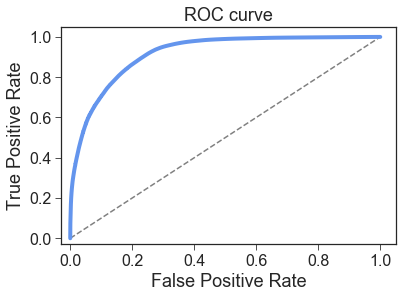

In [20]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test[:,:,:,1].ravel(), y_proba[:,:,:,1].ravel())

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    sns.lineplot(x=fpr, y=tpr, estimator=None, color='cornflowerblue', linewidth=4, label=label)
    plt.title("ROC curve")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.xlim([-0.03, 1.05])
    plt.ylim([-0.03, 1.05])

plot_roc_curve(fpr, tpr)

auc(fpr, tpr)
# plt.savefig('./results/ROC_original.png', bbox_inches='tight', dpi=300);

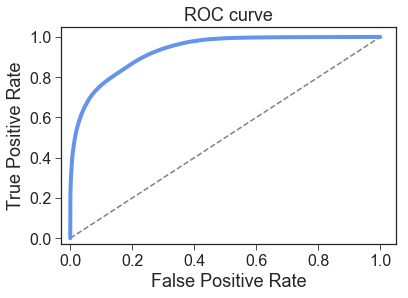

In [29]:
fpr0, tpr0, thresholds0 = roc_curve(y_test[:,:,:,1].ravel(), y_proba[:,:,:,1].ravel())
plot_roc_curve(fpr0, tpr0)

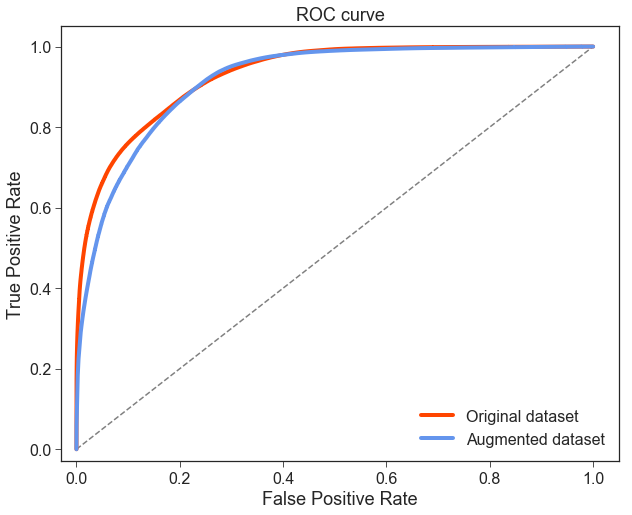

In [42]:
plt.rcParams['figure.figsize'] = (10, 8)
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
sns.lineplot(x=fpr0, y=tpr0, estimator=None, color='orangered', linewidth=4, label='Original dataset')
sns.lineplot(x=fpr, y=tpr, estimator=None, color='cornflowerblue', linewidth=4, label="Augmented dataset")
plt.title("ROC curve")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([-0.03, 1.05])
plt.ylim([-0.03, 1.05]);
plt.legend(fontsize=16);
# plt.savefig('./results/ROCx2.png', bbox_inches='tight', dpi=300);

** Evaluate on validation set**

In [ ]:
X_val, y_val = LoadBatches.imageSegmentationArray(val_images_path, val_segs_path, 
                                                    val_batch_size, n_classes,
                                                    input_height, input_width, 
                                                    output_height, output_width)

print(X_val.shape, y_val.shape, X_val[0].shape)

In [ ]:
m.evaluate(x=X_val, y=y_val, batch_size=val_batch_size)